01_import dataset
===

In [2]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


02_rename variable in each data set
===

In [3]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




03_變數型態統一及缺失值處理
===

In [4]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")
cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = -1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(-2)
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [ ]:
##不用執行～～(本來試圖建立對照表將Missing的zip補上)

##檢查89006筆Missing的zip
c_missing_zip = transactions_df[transactions_df["zip"].isna()]
c_mexico_zip = transactions_df[transactions_df["merchant_state"]=="Mexico"]
#c_mcc_mv_zip = c_missing_zip[
#    (c_missing_zip["mcc_code"] > 5400) & (c_missing_zip["mcc_code"] < 5700)
#]



# 先建立 mapping table：一組 state+city 可能對應多個 zip
mapping_df = (
    transactions_df
    .dropna(subset=["zip"])                                   # 只要 zip 有值的 row
    .drop_duplicates(subset=["merchant_state", "merchant_city", "zip"]) 
    [["merchant_state", "merchant_city", "zip"]]              # 只留下需要的欄位
)

print(mapping_df.head())


# 假設 df 已經存在
# 建立新的欄位 F，B 與 C 合併
c_missing_zip["fullname"] = c_missing_zip["merchant_city"].astype(str) + c_missing_zip["merchant_state"].astype(str)
# 建立新的 DataFrame，只取 A, D, F
df_small = c_missing_zip[["transaction_id", "fullname","zip"]]

mapping_df["mfullname"] = mapping_df["merchant_city"].astype(str) + mapping_df["merchant_state"].astype(str)

# 先建立一個 lookup 字典
lookup_dict = dict(zip(mapping_df["mfullname"], mapping_df["zip"]))

# 用 map 當作 vlookup
df_small["zip"] = df_small["zip"].fillna(df_small["fullname"].map(lookup_dict))




05_data資料整合
===

In [ ]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="inner")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

In [6]:
del transactions_df, users_df, cards_df, train_fraud_labels_df

In [ ]:
merged.to_csv("merged.csv", index=False)

06_EDA_Exploratory-Data-Analysis
==

In [7]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   transaction_id         int64         
 1   date                   datetime64[ns]
 2   client_id_x            int64         
 3   card_id                int64         
 4   amount                 int64         
 5   use_chip               category      
 6   merchant_id            int64         
 7   merchant_city          object        
 8   merchant_state         object        
 9   zip                    int64         
 10  mcc_code               int64         
 11  errors                 category      
 12  is_fraud               category      
 13  current_age            int64         
 14  retirement_age         int64         
 15  birth_year             period[Y-DEC] 
 16  birth_month            period[M]     
 17  gender                 category      
 18  address               

In [8]:
merged.describe()

,transaction_id,date,client_id_x,card_id,amount,merchant_id,zip,mcc_code,current_age,retirement_age,...,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,client_id_y,card_number,cvv,num_cards_issued,credit_limit
count,8.914963e+06,8914963,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,...,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06,8.914963e+06
mean,1.558473e+07,2015-01-06 10:38:50.359852288,1.026637e+03,3.474887e+03,4.252761e+01,4.772566e+04,4.495262e+04,5.565097e+03,5.402147e+01,6.648777e+01,...,2.398357e+04,4.669135e+04,5.802153e+04,7.139262e+02,3.841198e+00,1.026637e+03,4.817349e+15,4.953292e+02,1.522064e+00,1.554959e+04
min,7.475327e+06,2010-01-01 00:01:00,0.000000e+00,0.000000e+00,-5.000000e+02,1.000000e+00,-2.000000e+00,1.711000e+03,2.300000e+01,5.300000e+01,...,0.000000e+00,1.000000e+00,0.000000e+00,4.880000e+02,1.000000e+00,0.000000e+00,3.001055e+14,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.150786e+07,2012-08-09 10:34:00,5.190000e+02,2.413000e+03,8.000000e+00,2.588700e+04,1.507800e+04,5.300000e+03,4.200000e+01,6.500000e+01,...,1.711300e+04,3.281700e+04,1.643700e+04,6.840000e+02,3.000000e+00,5.190000e+02,4.489873e+15,2.470000e+02,1.000000e+00,8.100000e+03
50%,1.557140e+07,2015-01-22 14:06:00,1.070000e+03,3.584000e+03,2.800000e+01,4.592600e+04,4.110200e+04,5.499000e+03,5.200000e+01,6.600000e+01,...,2.115600e+04,4.109100e+04,5.167900e+04,7.160000e+02,4.000000e+00,1.070000e+03,5.112842e+15,4.990000e+02,2.000000e+00,1.345500e+04
75%,1.965387e+07,2017-06-13 19:22:30,1.530000e+03,4.899000e+03,6.300000e+01,6.757000e+04,7.550100e+04,5.812000e+03,6.300000e+01,6.800000e+01,...,2.730800e+04,5.401300e+04,8.516000e+04,7.560000e+02,5.000000e+00,1.530000e+03,5.566696e+15,7.400000e+02,2.000000e+00,2.083900e+04
max,2.376187e+07,2019-10-31 23:57:00,1.998000e+03,6.138000e+03,6.613000e+03,1.003420e+05,9.992800e+04,9.402000e+03,1.010000e+02,7.900000e+01,...,1.631450e+05,2.801990e+05,4.618540e+05,8.500000e+02,9.000000e+00,1.998000e+03,6.994218e+15,9.990000e+02,3.000000e+00,1.413910e+05
std,4.703991e+06,NaN,5.816755e+02,1.674427e+03,8.151282e+01,2.581623e+04,3.230916e+04,8.755078e+02,1.572477e+01,3.587085e+00,...,1.197540e+04,2.445588e+04,5.209717e+04,6.581489e+01,1.567701e+00,5.816755e+02,1.311465e+15,2.885735e+02,5.151711e-01,1.218199e+04


In [9]:
merged.describe(include='all')

,transaction_id,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
count,8.914963e+06,8914963,8.914963e+06,8.914963e+06,8.914963e+06,8914963,8.914963e+06,8914963,8914963,8.914963e+06,...,8914963,8.914963e+06,8914963,8.914963e+06,8914963,8.914963e+06,8.914963e+06,8914963,8914963,8914963
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,12173,200,NaN,...,3,NaN,180,NaN,2,NaN,NaN,294,19,1
top,NaN,NaN,NaN,NaN,NaN,Swipe Transaction,NaN,ONLINE,online,NaN,...,Debit,NaN,2020-02,NaN,YES,NaN,NaN,2010-02,2011,No
freq,NaN,NaN,NaN,NaN,NaN,4668212,NaN,1047865,1047865,NaN,...,5548196,NaN,315683,NaN,8022614,NaN,NaN,165220,1623136,8914963
mean,1.558473e+07,2015-01-06 10:38:50.359852288,1.026637e+03,3.474887e+03,4.252761e+01,NaN,4.772566e+04,NaN,NaN,4.495262e+04,...,NaN,4.817349e+15,NaN,4.953292e+02,NaN,1.522064e+00,1.554959e+04,NaN,NaN,NaN
min,7.475327e+06,2010-01-01 00:01:00,0.000000e+00,0.000000e+00,-5.000000e+02,NaN,1.000000e+00,NaN,NaN,-2.000000e+00,...,NaN,3.001055e+14,NaN,0.000000e+00,NaN,1.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,1.150786e+07,2012-08-09 10:34:00,5.190000e+02,2.413000e+03,8.000000e+00,NaN,2.588700e+04,NaN,NaN,1.507800e+04,...,NaN,4.489873e+15,NaN,2.470000e+02,NaN,1.000000e+00,8.100000e+03,NaN,NaN,NaN
50%,1.557140e+07,2015-01-22 14:06:00,1.070000e+03,3.584000e+03,2.800000e+01,NaN,4.592600e+04,NaN,NaN,4.110200e+04,...,NaN,5.112842e+15,NaN,4.990000e+02,NaN,2.000000e+00,1.345500e+04,NaN,NaN,NaN
75%,1.965387e+07,2017-06-13 19:22:30,1.530000e+03,4.899000e+03,6.300000e+01,NaN,6.757000e+04,NaN,NaN,7.550100e+04,...,NaN,5.566696e+15,NaN,7.400000e+02,NaN,2.000000e+00,2.083900e+04,NaN,NaN,NaN
max,2.376187e+07,2019-10-31 23:57:00,1.998000e+03,6.138000e+03,6.613000e+03,NaN,1.003420e+05,NaN,NaN,9.992800e+04,...,NaN,6.994218e+15,NaN,9.990000e+02,NaN,3.000000e+00,1.413910e+05,NaN,NaN,NaN


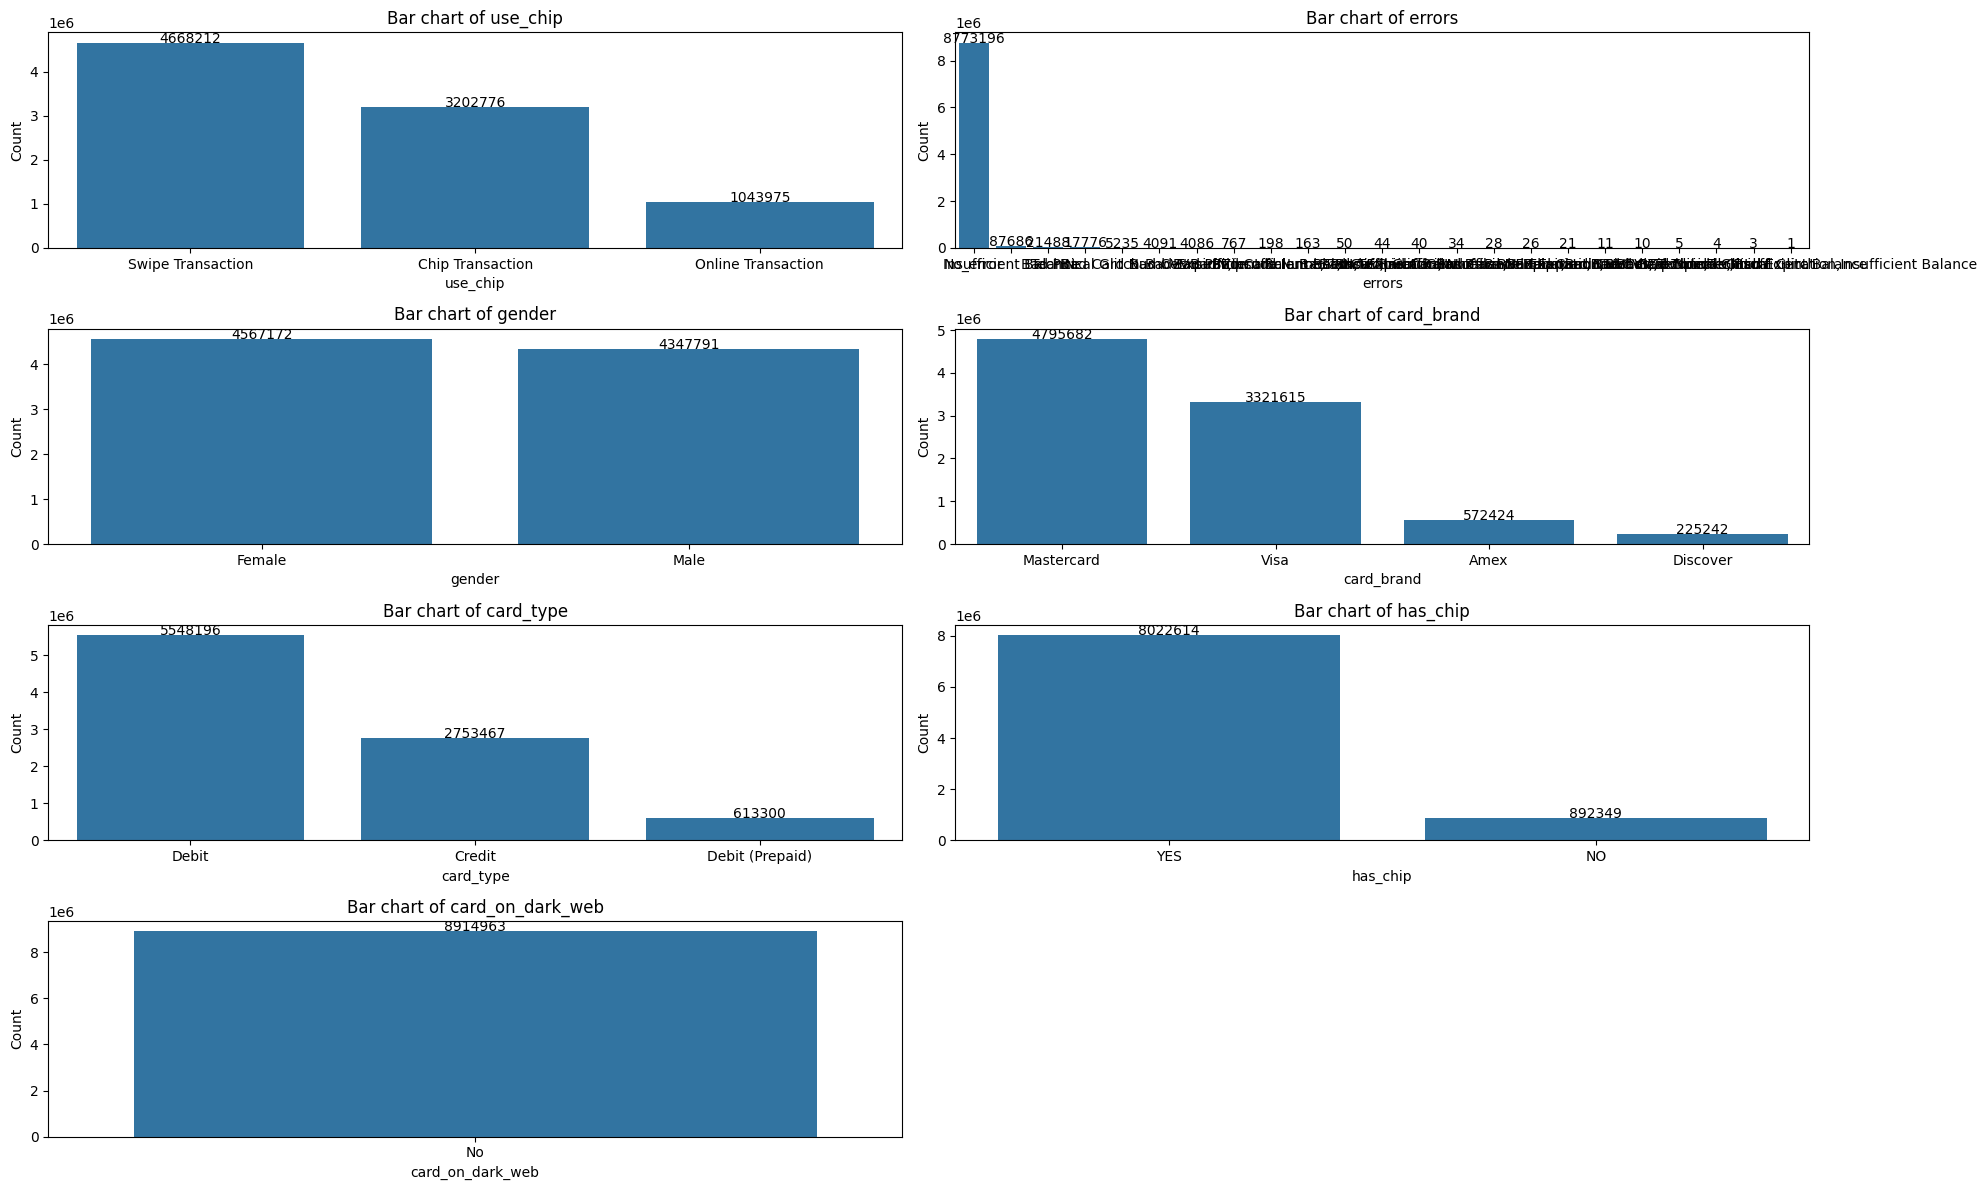

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = merged.select_dtypes(include=["category"]).columns

n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=merged, x=col, order=merged[col].value_counts().index, ax=ax)
    ax.set_title(f"Bar chart of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=0)  # X軸標籤旋轉
    
    # 在長條圖上加數字
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width()/2,
                y=height + 0.05,
                s=int(height),
                ha='center')

# 移除多餘空白子圖
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


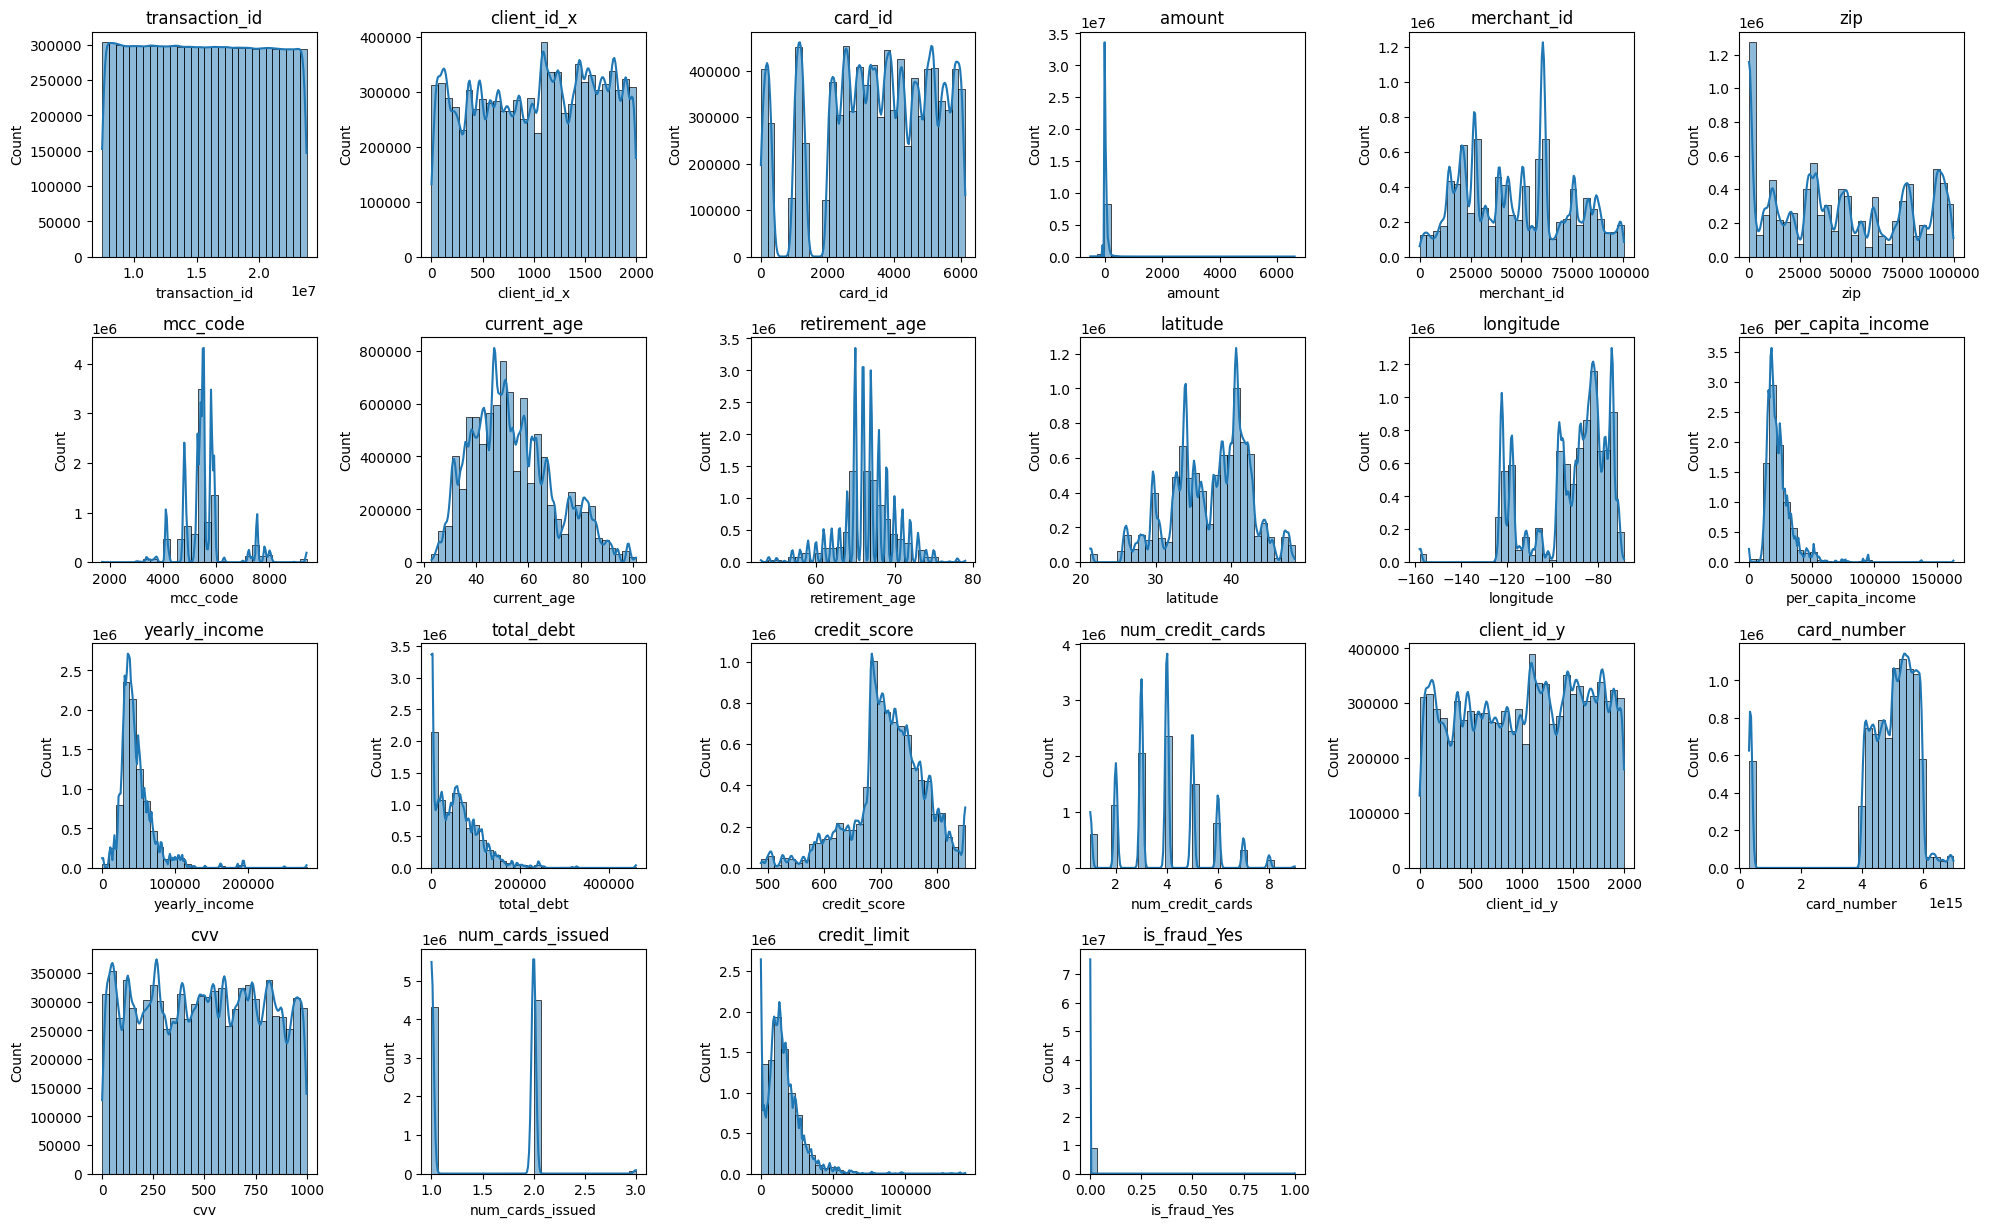

In [17]:
# 設定 subplot 格式
n_cols = 6   # 每列放6張圖
n_rows = 5   # 每行放5列 (共 5x6=30)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))  # 調整大小
axes = axes.flatten()  # 攤平成一維方便迭代

for i, col in enumerate(num_cols):
    sns.histplot(data=merged, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# 把多餘的 subplot 關掉（避免空白框）
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
##畫不出來:)

num_cols = merged.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(merged[num_cols])

In [ ]:
cols_to_encode = ['is_fraud']
merged[cols_to_encode] = merged[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    merged[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
merged = pd.concat([merged, dummies_cards], axis=1)



In [13]:
merged.drop(columns=["is_fraud_No","is_fraud"], inplace=True)

In [ ]:
merged["is_fraud_Yes"]=merged["is_fraud_Yes"].astype("int64")
target = 'is_fraud_Yes'  # 假設這是目標
num_cols = merged.select_dtypes(include=['int64','float64']).columns.drop(target)

for col in num_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(merged[col], merged[target], alpha=0.3)  # alpha降低透明度，避免太擠
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"{target} vs {col}")
    plt.show()

In [ ]:
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
cols_to_encode = ['card_type', 'card_brand']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_chip = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_chip], axis=1)

In [ ]:
#cars one heart encoding